<a href="https://colab.research.google.com/github/anega006/Autoencoders/blob/master/Semantic_Hair_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install tensorflow==1.15
!pip install --upgrade tensorflow==1.15

     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
     |████████████████████████████████| 512kB 49.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a7b5fd0c4c7288a3aaeb3bb3d2f5d5f320928c09ad24f49f116fbdd2e11fb7e8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

In [0]:
!pip install httplib2==0.15.0

     |████████████████████████████████| 102kB 4.2MB/s 
ERROR: google-api-python-client 1.7.12 has requirement httplib2<1dev,>=0.17.0, but you'll have httplib2 0.15.0 which is incompatible.
  Found existing installation: httplib2 0.17.3
    Uninstalling httplib2-0.17.3:
      Successfully uninstalled httplib2-0.17.3


In [0]:
# Preparing to export data directly to google drive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
!mv /tmp/colab_util_repo/colab_util.py colab_util.py

In [0]:
!rm -r /tmp/colab_util_repo

In [0]:
# Downloading the Figaro1K dataset
!wget -c http://projects.i-ctm.eu/sites/default/files/AltroMateriale/207_Michele%20Svanera/Figaro1k.zip

--2020-05-30 12:49:10--  http://projects.i-ctm.eu/sites/default/files/AltroMateriale/207_Michele%20Svanera/Figaro1k.zip
Resolving projects.i-ctm.eu (projects.i-ctm.eu)... 94.23.64.16
Connecting to projects.i-ctm.eu (projects.i-ctm.eu)|94.23.64.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66542098 (63M) [application/zip]
Saving to: ‘Figaro1k.zip’

Figaro1k.zip        100%[===================>]  63.46M  16.6MB/s    in 3.8s    

2020-05-30 12:49:15 (16.6 MB/s) - ‘Figaro1k.zip’ saved [66542098/66542098]



In [0]:
!unzip -uq "./Figaro1k.zip"

In [0]:
!rm -rf "./__MACOSX"

In [0]:
# Import necessary libraries
import os
import numpy as np
import pickle
import cv2
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Input, Softmax, DepthwiseConv2D, UpSampling2D, concatenate, Concatenate, Conv2DTranspose, ZeroPadding2D, ReLU, BatchNormalization, SeparableConv2D
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.utils import plot_model
import random
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# Initilaize paths
TRAIN_IMAGES_PATH = "./Figaro1k/Original/Training/"
TRAIN_MASKS_PATH = "./Figaro1k/GT/Training/"
TEST_IMAGES_PATH = "./Figaro1k/Original/Testing/"
TEST_MASKS_PATH = "./Figaro1k/GT/Testing/"
DUMP_DATA_PATH = "./pickled_data/"
LOGS_PATH = "./graphs/"
SAVE_MODEL_PATH = "./weights/"
SAVE_RESULTS_PATH = "./test_predictions/"

In [0]:
#Remove 14 redundant masks
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00118-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00418-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00460-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00555-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00561-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00698-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00705-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00761-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00829-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00895-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00924-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame00926-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame01008-gt(1).pbm'))
os.remove(os.path.join(TRAIN_MASKS_PATH, 'Frame01046-gt(1).pbm'))

In [0]:
# Create all the required paths
def create_necessary_directories():
  if (not os.path.exists(DUMP_DATA_PATH)):
    os.mkdir(DUMP_DATA_PATH)
  if (not os.path.exists(SAVE_MODEL_PATH)):
    os.mkdir(SAVE_MODEL_PATH)
  if (not os.path.exists(LOGS_PATH)):
    os.mkdir(LOGS_PATH)
  if (not os.path.exists(SAVE_RESULTS_PATH)):
    os.mkdir(SAVE_RESULTS_PATH)

create_necessary_directories()

In [0]:
# Initialize parameters
RESIZE_WIDTH = 224
RESIZE_HEIGHT = 224
OPTIMIZER = 'adam' 
LOSS_FUNCTION = 'binary_crossentropy'
BATCH_SIZE = 16
EPOCHS = 100

In [0]:
# Creating list of images in sorted manner
# So that training_images remain binded with training_masks
train_images = sorted(os.listdir(TRAIN_IMAGES_PATH))
train_masks = sorted(os.listdir(TRAIN_MASKS_PATH))
test_images = sorted(os.listdir(TEST_IMAGES_PATH))
test_masks = sorted(os.listdir(TEST_MASKS_PATH))

In [0]:
X_test = test_images
y_test = test_masks

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.25, random_state=42)

In [0]:
print("Total number of images in the training set: ", len(X_train))
print("Total number of images in the validation set: ", len(X_val))
print("Total number of images in the testing set: ", len(X_test))

Total number of images in the training set:  630
Total number of images in the validation set:  210
Total number of images in the testing set:  210


In [0]:
#Function to preprocess images
def preprocess_data():
    
    #Initialize empty lists
    oTrainImages = []
    oValImages = []
    oTestImages = []
    oTrainMasks = []
    oValMasks = []
    oTestMasks = []

    #Preprocessing train_images
    for filename in X_train:
        oImg = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, filename))
        oImg = cv2.cvtColor(oImg, cv2.COLOR_BGR2RGB)
        oResizedImg = cv2.resize(oImg, (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)  
        oReshapedImg = oResizedImg.reshape(RESIZE_HEIGHT, RESIZE_WIDTH, 3)
        oNormalizedImg = oReshapedImg.astype('float32')/255.0
        oTrainImages.append(oNormalizedImg)

    #Preprocessing val_images
    for filename in X_val:
        oImg = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, filename))
        oImg = cv2.cvtColor(oImg, cv2.COLOR_BGR2RGB)
        oResizedImg = cv2.resize(oImg, (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)  
        oReshapedImg = oResizedImg.reshape(RESIZE_HEIGHT, RESIZE_WIDTH, 3)
        oNormalizedImg = oReshapedImg.astype('float32')/255.0
        oValImages.append(oNormalizedImg)

    #Preprocessing test_images
    for filename in X_test:
        oImg = cv2.imread(os.path.join(TEST_IMAGES_PATH, filename))
        oImg = cv2.cvtColor(oImg, cv2.COLOR_BGR2RGB)
        oResizedImg = cv2.resize(oImg, (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)
        oReshapedImg = oResizedImg.reshape(RESIZE_HEIGHT, RESIZE_WIDTH, 3)
        oNormalizedImg = oReshapedImg.astype('float32')/255.0
        oTestImages.append(oNormalizedImg)

    #Preprocessing train_masks
    for filename in y_train:
        oImg = cv2.imread(os.path.join(TRAIN_MASKS_PATH, filename), 0)
        oResizedImg = cv2.resize(oImg, (RESIZE_WIDTH, RESIZE_HEIGHT))
        oReshapedImg = oResizedImg.reshape(RESIZE_HEIGHT, RESIZE_WIDTH, 1)
        oNormalizedImg = oReshapedImg.astype('float32')/255.0
        oTrainMasks.append(oNormalizedImg)

    #Preprocessing val_masks
    for filename in y_val:
        oImg = cv2.imread(os.path.join(TRAIN_MASKS_PATH, filename), 0)
        oResizedImg = cv2.resize(oImg, (RESIZE_WIDTH, RESIZE_HEIGHT))
        oReshapedImg = oResizedImg.reshape(RESIZE_HEIGHT, RESIZE_WIDTH, 1)
        oNormalizedImg = oReshapedImg.astype('float32')/255.0
        oValMasks.append(oNormalizedImg)

    #Preprocessing test_masks
    for filename in y_test:
        oImg = cv2.imread(os.path.join(TEST_MASKS_PATH, filename), 0)
        oResizedImg = cv2.resize(oImg, (RESIZE_WIDTH, RESIZE_HEIGHT))
        oReshapedImg = oResizedImg.reshape(RESIZE_HEIGHT, RESIZE_WIDTH, 1)
        oNormalizedImg = oReshapedImg.astype('float32')/255.0
        oTestMasks.append(oNormalizedImg)

    #Conversion to a numpy array
    oTrainImagesNp = np.array(oTrainImages) 
    oValImagesNp = np.array(oValImages)    
    oTestImagesNp = np.array(oTestImages)  
    oTrainMasksNp = np.array(oTrainMasks) 
    oValMasksNp = np.array(oValMasks)  
    oTestMasksNp = np.array(oTestMasks)      

    return (oTrainImagesNp, oValImagesNp, oTestImagesNp, oTrainMasksNp, oValMasksNp, oTestMasksNp)

In [0]:
#Preprocess the data
oTrainImgArrayNp, oValImgArrayNp, oTestImgArrayNp, oTrainMaskArrayNp, oValMaskArrayNp, oTestMaskArrayNp = preprocess_data()

In [0]:
print("oTrainImgArrayNp.shape : ", oTrainImgArrayNp.shape)
print("oValImgArrayNp.shape : ", oValImgArrayNp.shape)
print("oTestImgArrayNp.shape : ", oTestImgArrayNp.shape)
print("oTrainMaskArrayNp.shape : ", oTrainMaskArrayNp.shape)
print("oValMaskArrayNp.shape : ", oValMaskArrayNp.shape)
print("oTestMaskArrayNp.shape : ", oTestMaskArrayNp.shape)

oTrainImgArrayNp.shape :  (630, 224, 224, 3)
oValImgArrayNp.shape :  (210, 224, 224, 3)
oTestImgArrayNp.shape :  (210, 224, 224, 3)
oTrainMaskArrayNp.shape :  (630, 224, 224, 1)
oValMaskArrayNp.shape :  (210, 224, 224, 1)
oTestMaskArrayNp.shape :  (210, 224, 224, 1)


In [0]:
#Function to pickle dump the data
def pickle_dump_data(oTrainImgArrayNp, oValImgArrayNp, oTestImgArrayNp, oTrainMaskArrayNp, oValMaskArrayNp, oTestMaskArrayNp):

    #Pickling & dumping training images
    pickling_on=open(DUMP_DATA_PATH+"oTrainImgArrayNp.pickle","wb")
    pickle.dump(oTrainImgArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping training labels
    pickling_on=open(DUMP_DATA_PATH+"oValImgArrayNp.pickle","wb")
    pickle.dump(oValImgArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping validation images
    pickling_on=open(DUMP_DATA_PATH+"oTestImgArrayNp.pickle","wb")
    pickle.dump(oTestImgArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping training images
    pickling_on=open(DUMP_DATA_PATH+"oTrainMaskArrayNp.pickle","wb")
    pickle.dump(oTrainMaskArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping training labels
    pickling_on=open(DUMP_DATA_PATH+"oValMaskArrayNp.pickle","wb")
    pickle.dump(oValMaskArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping validation images
    pickling_on=open(DUMP_DATA_PATH+"oTestMaskArrayNp.pickle","wb")
    pickle.dump(oTestMaskArrayNp,pickling_on)
    pickling_on.close()

In [0]:
#Pickle dump the data
pickle_dump_data(oTrainImgArrayNp, oValImgArrayNp, oTestImgArrayNp, oTrainMaskArrayNp, oValMaskArrayNp, oTestMaskArrayNp)

In [0]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    x = ZeroPadding2D(padding=(1, 1))(inputs)
    x = Conv2D(filters, kernel, padding='valid', use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=-1,momentum=0.1,epsilon=1e-05)(x)
    x = ReLU(6.)(x)
    return x

def _depthwise_conv_block(inputs, pointwise_conv_filters, depth_multiplier=1, strides=(1, 1), block_id=1):
    if strides == (1, 1):
        x = inputs
    else:
        x = ZeroPadding2D(padding=(1, 1))(inputs)

    x = DepthwiseConv2D((3, 3),padding='same' if strides == (1, 1) else 'valid',depth_multiplier=depth_multiplier,
                        strides=strides,use_bias=False,)(x)
    x = BatchNormalization(axis=-1,epsilon=1e-05,momentum=0.1)(x)
    x = ReLU(6.)(x)
    x = Conv2D(pointwise_conv_filters, (1, 1),padding='same',use_bias=False,strides=(1, 1))(x)
    x = BatchNormalization(axis=-1,epsilon=1e-05,momentum=0.1)(x)
    x = ReLU(6.)(x)
    return x

def upsampling_block(inputs):
    return UpSampling2D(size=(2, 2))(inputs)

def separable_conv_block(inputs, filters, block_id, kernel_size=(3, 3), stride=(1, 1)):
    x = ZeroPadding2D(padding=(1, 1))(inputs)
    x = SeparableConv2D(filters=filters,kernel_size=kernel_size,strides=stride,use_bias=False)(x)
    x = ReLU()(x)
    return x

def concluding_block(inputs, filters, kernel_size=(1, 1)):
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=(1, 1), name="decoder_output")(inputs)
    return x

def autoencoder():
    img_input = Input(shape=(RESIZE_HEIGHT, RESIZE_WIDTH, 3), name="input")

    x = _conv_block(img_input, 32, strides=(2, 2))
    skip1 = _depthwise_conv_block(x, 64, block_id=1)  # skip1 1

    x = _depthwise_conv_block(skip1, 128, strides=(2, 2), block_id=2)
    skip2 = _depthwise_conv_block(x, 128, block_id=3)  # skip2 3

    x = _depthwise_conv_block(skip2, 256, strides=(2, 2), block_id=4)
    skip3 = _depthwise_conv_block(x, 256, block_id=5)  # skip3 5

    x = _depthwise_conv_block(skip3, 512, strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, block_id=7)
    x = _depthwise_conv_block(x, 512, block_id=8)
    x = _depthwise_conv_block(x, 512, block_id=9)
    x = _depthwise_conv_block(x, 512, block_id=10)
    skip4 = _depthwise_conv_block(x, 512, block_id=11)  # skip4 11

    x = _depthwise_conv_block(skip4, 1024, strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, block_id=13)
    x = _depthwise_conv_block(x, 1024, block_id=14)

    x = upsampling_block(x)
    x = Concatenate(axis=-1)([x, skip4])
    x = separable_conv_block(x, 64, 1)

    x = upsampling_block(x)
    x = Concatenate(axis=-1)([x, skip3])
    x = separable_conv_block(x, 64, 2)

    x = upsampling_block(x)
    x = Concatenate(axis=-1)([x, skip2])
    x = separable_conv_block(x, 64, 3)

    x = upsampling_block(x)
    x = Concatenate(axis=-1)([x, skip1])
    x = separable_conv_block(x, 64, 4)

    x = upsampling_block(x)
    x = Concatenate(axis=-1)([x, img_input])
    x = separable_conv_block(x, 64, 5)

    x = concluding_block(x, 1)

    model = Model(img_input, x, name="Semantic Hair Segmentation Model")

    return model

In [0]:
# Initialize autoencoder model
model = autoencoder()

# Print model summary
print(model.summary())

Model: "Semantic Hair Segmentation Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 226, 226, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 112, 112, 32) 864         zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 112, 112, 32) 128         conv2d_16[0][0]                  
___________________________________________________________________

In [0]:
#Compile the model
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

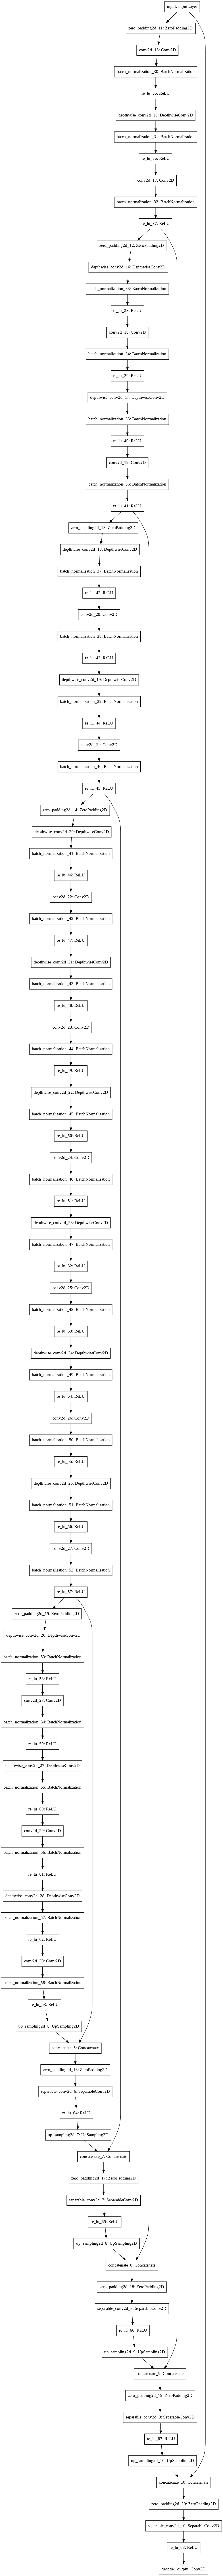

In [0]:
# Plot model summary to an image
plot_model(model, to_file='model_summary.png')

In [0]:
# Define filepath for each model to be saved
oWeightFilePath = os.path.join(SAVE_MODEL_PATH, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")

# Create model checkpoint callback
iEpochs = 1
checkpoint_callback = ModelCheckpoint(oWeightFilePath, 
                                      monitor='loss', 
                                      verbose=1,  
                                      period=iEpochs)

# Create tensorboard callback
tensorboard_callback = TensorBoard(log_dir=LOGS_PATH, 
                                   batch_size=BATCH_SIZE, 
                                   write_graph=True, 
                                   write_grads=True, 
                                   write_images=True, 
                                   update_freq='epoch')

In [0]:
# Train the model
history = model.fit(x=oTrainImgArrayNp, 
                    y=oTrainMaskArrayNp, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1, 
                    callbacks=[checkpoint_callback, tensorboard_callback], 
                    validation_data=(oValImgArrayNp, oValMaskArrayNp))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 630 samples, validate on 210 samples


Epoch 1/100
630/630 [==============================] - 22s 36ms/step - loss: 0.8864 - accuracy: 0.6970 - val_loss: 0.4607 - val_accuracy: 0.7830

Epoch 00001: saving model to ./weights/weights-improvement-01-0.78.hdf5

Epoch 2/100
630/630 [==============================] - 12s 19ms/step - loss: 0.4276 - accuracy: 0.8114 - val_loss: 0.3770 - val_accuracy: 0.8544

Epoch 00002: saving model to ./weights/weights-improvement-02-0.85.hdf5
Epoch 3/100
630/630 [==============================] - 12s 19ms/step - loss: 0.3622 - accuracy: 0.8498 - val_loss: 0.3087 - val_accuracy: 0.8716

Epoch 00003: saving model to ./weights/weights-improvement-03-0.87.hdf5
Epoch 4/100
630/630 [==============================] - 12s 19ms/step - loss: 0.2909 - accuracy: 0.8807 - val_loss: 0.3668 - val_accuracy: 0.8503

Epoch 00004: saving model to ./weights/weights-improveme

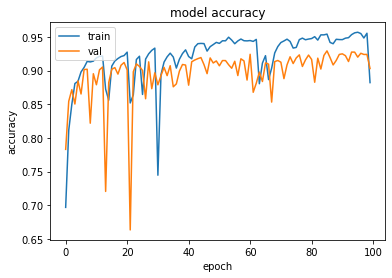

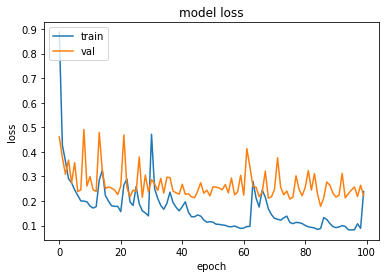

In [0]:
#Function to plot model history
def plot_model_history(history):
  
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('accuracy_curve.png')
    plt.show()
    

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

#Plot model history
plot_model_history(history)

In [0]:
#Load the best model
model = load_model("./weights/weights-improvement-86-0.93.hdf5")

# Save the model and weights as autoencoder model
model.save('./semantic_segmentation_autoencoder.hdf5')

In [0]:
#Evaluate the model
oTrainScore = model.evaluate(oTrainImgArrayNp, oTrainMaskArrayNp, batch_size=BATCH_SIZE)
oValScore = model.evaluate(oValImgArrayNp, oValMaskArrayNp, batch_size=BATCH_SIZE)

print("oTrainScore: " , oTrainScore)
print("oValScore: ", oValScore)

210/210 [==============================] - 1s 3ms/step
oTrainScore:  [0.1020863733121327, 0.9573269486427307]
oValScore:  [0.17889645255747297, 0.9291697144508362]


In [0]:
# Calculate reconstruction Error
reconstruction_error = model.evaluate(oTestImgArrayNp, oTestMaskArrayNp, batch_size=BATCH_SIZE, verbose=0)
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: [0.15728727593308403, 0.9343276619911194]


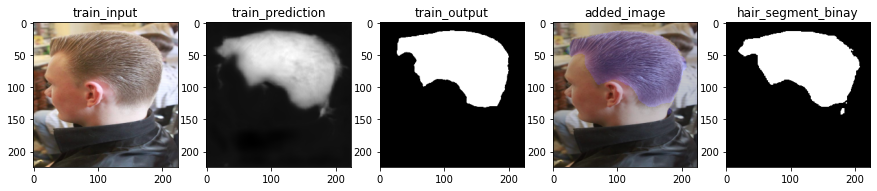

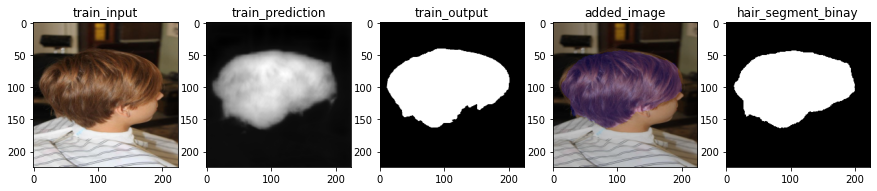

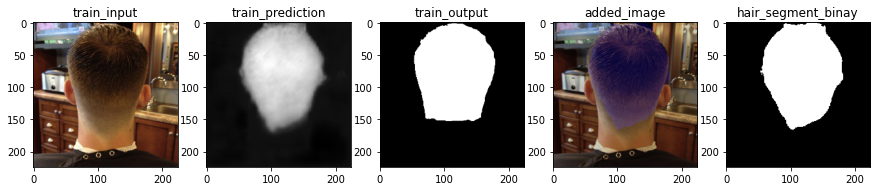

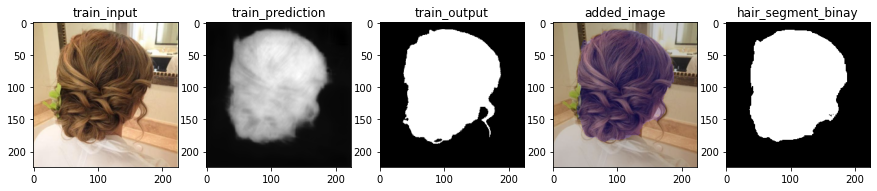

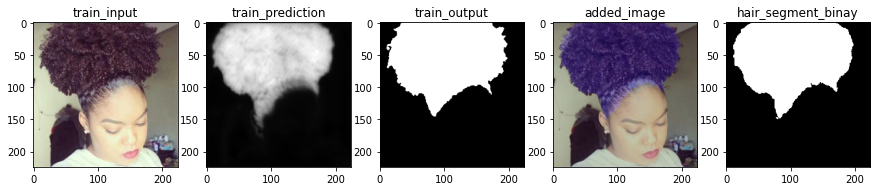

In [0]:
# Function to plot model predictions on training data
threshold_hair = 0.5 #Threshold for binarization
 
def show_train_results(oTrainImgArrayNp, oTrainMaskArrayNp, oTrainPredictionsNp):
   n = 5
   for i in range(1, n+1):
       train_input = oTrainImgArrayNp[i]
       train_prediction= oTrainPredictionsNp[i]
       train_output = oTrainMaskArrayNp[i]
       preds_hair_segment_binay = (train_prediction > threshold_hair).astype(np.uint8)
       mask_n = np.zeros((RESIZE_HEIGHT, RESIZE_WIDTH,3))
       mask_n[:, :, 2] = preds_hair_segment_binay[:, :, 0]
      #  print(train_input.shape, mask_n.shape)
       added_image = cv2.addWeighted(train_input, 0.8, mask_n, 0.2, 0, dtype = cv2.CV_32F)
 
       f, ax = plt.subplots(1,5, figsize=(15,12))
       ax[0].imshow(np.squeeze(train_input))
       ax[0].title.set_text('train_input')
       ax[1].imshow(np.squeeze(train_prediction), cmap='gray')
       ax[1].title.set_text('train_prediction')
       ax[2].imshow(np.squeeze(train_output), cmap='gray')
       ax[2].title.set_text('train_output')
       ax[3].imshow(np.squeeze(added_image))
       ax[3].title.set_text('added_image')
       ax[4].imshow(np.squeeze(preds_hair_segment_binay), cmap='gray')
       ax[4].title.set_text('hair_segment_binay')
       plt.show()
 
 
oTrainPredictionsNp = model.predict(oTrainImgArrayNp)
show_train_results(oTrainImgArrayNp, oTrainMaskArrayNp, oTrainPredictionsNp)

In [0]:
#Calculate predictions of model on test data
oTestPredictionsNp = model.predict(oTestImgArrayNp)

print("oTestImgArrayNp.shape", oTestImgArrayNp.shape)
print("oTestPredictionsNp.shape", oTestPredictionsNp.shape)

oTestImgArrayNp.shape (210, 224, 224, 3)
oTestPredictionsNp.shape (210, 224, 224, 1)


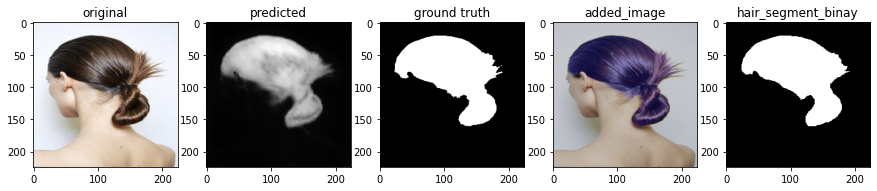

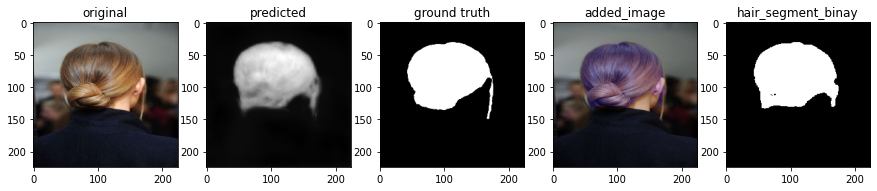

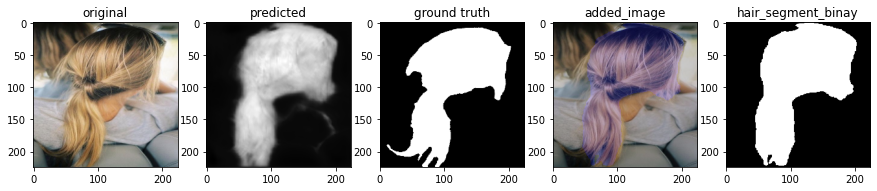

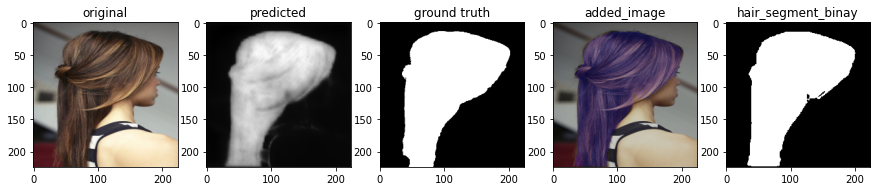

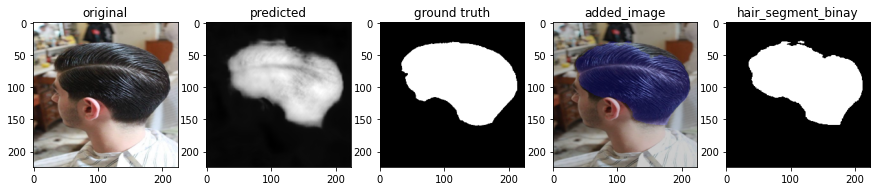

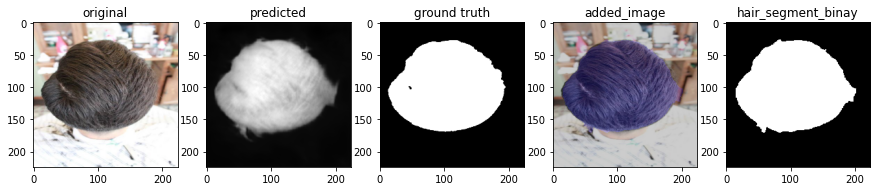

In [0]:
#Function to print the test results
def save_test_results(oTestImgArrayNp, oTestMaskArrayNp, oTestPredictionsNp):
    n = 5
    for i in range(15, n+16):
        actual_img = oTestImgArrayNp[i]
        test_result= oTestPredictionsNp[i]
        test_actual = oTestMaskArrayNp[i]
        preds_hair_segment_binay = (test_result > threshold_hair).astype(np.uint8)
        mask_n = np.zeros((RESIZE_HEIGHT, RESIZE_WIDTH,3))
        mask_n[:, :, 2] = preds_hair_segment_binay[:, :, 0]
        added_image = cv2.addWeighted(actual_img, 0.8, mask_n, 0.2, 0, dtype = cv2.CV_32F)
 
        f, ax = plt.subplots(1,5, figsize=(15,12))
        ax[0].imshow(np.squeeze(actual_img))
        ax[0].title.set_text('original')
        ax[1].imshow(np.squeeze(test_result), cmap='gray')
        ax[1].title.set_text('predicted')
        ax[2].imshow(np.squeeze(test_actual), cmap='gray')
        ax[2].title.set_text('ground truth')
        ax[3].imshow(np.squeeze(added_image))
        ax[3].title.set_text('added_image')
        ax[4].imshow(np.squeeze(preds_hair_segment_binay), cmap='gray')
        ax[4].title.set_text('hair_segment_binay')
        plt.savefig(os.path.join(SAVE_RESULTS_PATH, "test" + str(i) + ".png"))
        plt.show()

#Save test results
save_test_results(oTestImgArrayNp, oTestMaskArrayNp, oTestPredictionsNp)

In [0]:
# Configure Google drive to export data
from colab_util import *
drive_handler = GoogleDriveHandler()

In [0]:
def upload_files_to_drive(archive_name, files_to_be_archived):

  # Create a combined tar file
  tar_file_path = create_archive(archive_name, local_file_paths=files_to_be_archived, temp_folder='.', verbose=True)
  
  # Create folder inside google drive 
  project_folder_id = drive_handler.create_folder('Semantic Hair Segmentation')

  # Upload the data
  drive_handler.upload(tar_file_path, parent_path='Semantic Hair Segmentation')

In [0]:
# Upload processed image np arrays to google drive
upload_files_to_drive(archive_name="image_array_archive", 
                      files_to_be_archived = ["./pickled_data/oTrainImgArrayNp.pickle",
                                              "./pickled_data/oTrainMaskArrayNp.pickle",
                                              "./pickled_data/oValImgArrayNp.pickle",
                                              "./pickled_data/oValMaskArrayNp.pickle",
                                              "./pickled_data/oTestImgArrayNp.pickle",
                                              "./pickled_data/oTestMaskArrayNp.pickle"])

ignore the common prefix ./pickled_data/
running shell command: 
tar -czvf ./image_array_archive.tar.gz -C ./pickled_data/ oTrainImgArrayNp.pickle oTrainMaskArrayNp.pickle oValImgArrayNp.pickle oValMaskArrayNp.pickle oTestImgArrayNp.pickle oTestMaskArrayNp.pickle
oTrainImgArrayNp.pickle
oTrainMaskArrayNp.pickle
oValImgArrayNp.pickle
oValMaskArrayNp.pickle
oTestImgArrayNp.pickle
oTestMaskArrayNp.pickle



In [0]:
# Upload model summary and curves to google drive
upload_files_to_drive(archive_name="curves_and_summary_archive", 
                      files_to_be_archived = ["./model_summary.png",
                                              "./accuracy_curve.png",
                                              "./loss_curve.png"])

ignore the common prefix ./
running shell command: 
tar -czvf ./curves_and_summary_archive.tar.gz -C ./ model_summary.png accuracy_curve.png loss_curve.png
model_summary.png
accuracy_curve.png
loss_curve.png

Semantic Hair Segmentation already exists


In [0]:
# Upload the best model and weights to google drive
upload_files_to_drive(archive_name="model_weights_archive", 
                      files_to_be_archived = ["./semantic_segmentation_autoencoder.hdf5"])

ignore the common prefix ./
running shell command: 
tar -czvf ./model_weights_archive.tar.gz -C ./ semantic_segmentation_autoencoder.hdf5
semantic_segmentation_autoencoder.hdf5

Semantic Hair Segmentation already exists


In [0]:
# Upload the tensorboard graph to google drive
upload_files_to_drive(archive_name="tensorboard_graph_archive", 
                      files_to_be_archived = ["./graphs/events.out.tfevents.1590843403.281284269de6"])

ignore the common prefix ./graphs/
running shell command: 
tar -czvf ./tensorboard_graph_archive.tar.gz -C ./graphs/ events.out.tfevents.1590843403.281284269de6
events.out.tfevents.1590843403.281284269de6

Semantic Hair Segmentation already exists


In [0]:
upload_files_to_drive(archive_name="test_predictions_archive", 
                      files_to_be_archived = ["./test_predictions/test15.png",
                                              "./test_predictions/test16.png",
                                              "./test_predictions/test17.png",
                                              "./test_predictions/test18.png",
                                              "./test_predictions/test19.png",
                                              "./test_predictions/test20.png"])

ignore the common prefix ./test_predictions/
running shell command: 
tar -czvf ./test_predictions_archive.tar.gz -C ./test_predictions/ test15.png test16.png test17.png test18.png test19.png test20.png
test15.png
test16.png
test17.png
test18.png
test19.png
test20.png

Semantic Hair Segmentation already exists
